In [41]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

import sys

sys.path.append("../stochman/")

from stochman import nnj

# Define conv and conv transpose. Set weights equal to each other

In [88]:
conv = nnj.Conv2d(1,1,kernel_size=3,padding=1,stride=2)
conv

Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [106]:
conv_transpose = nnj.ConvTranspose2d(1,1,kernel_size=3,padding=1,stride=2)
conv_transpose.weight = conv.weight
conv_transpose

ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

# Define data

In [107]:
N = 10

tmp = torch.randint(0, 10, (1, N, N)).type(torch.float)
tmp

tensor([[[9., 9., 5., 5., 8., 3., 1., 5., 8., 2.],
         [7., 1., 5., 8., 0., 0., 9., 6., 9., 8.],
         [2., 9., 1., 9., 7., 4., 0., 7., 8., 6.],
         [0., 4., 6., 8., 4., 6., 6., 7., 0., 2.],
         [9., 2., 2., 7., 2., 1., 1., 1., 0., 8.],
         [2., 1., 1., 4., 4., 7., 6., 1., 5., 2.],
         [1., 9., 1., 9., 1., 6., 2., 5., 8., 5.],
         [9., 4., 1., 5., 8., 9., 6., 7., 2., 9.],
         [6., 7., 2., 2., 8., 4., 7., 4., 6., 9.],
         [8., 1., 7., 3., 2., 5., 6., 0., 1., 2.]]])

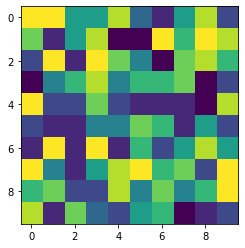

In [108]:
plt.imshow(tmp[0])

# Compute Jacobian of conv

In [109]:
x = tmp.unsqueeze(0).type(torch.float)
val = conv(x)
jac_in = torch.diag(torch.ones(N)).unsqueeze(0).unsqueeze(0).type(torch.float)

jacobian = conv._jacobian_mult(x, val, jac_in)
jacobian

tensor([[[[ 0.0260,  0.2291,  0.0000,  0.0000,  0.0000],
          [-0.1350,  0.1634,  0.2291,  0.0000,  0.0000],
          [ 0.0000, -0.1350,  0.1634,  0.2291,  0.0000],
          [ 0.0000,  0.0000, -0.1350,  0.1634,  0.2291],
          [ 0.0000,  0.0000,  0.0000, -0.1350,  0.1634]]]],
       grad_fn=<PermuteBackward0>)

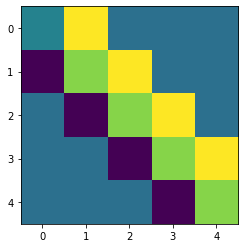

In [110]:
plt.imshow(jacobian.detach().numpy()[0,0])

# Compute Jacobian of conv transpose

In [111]:
x = tmp.unsqueeze(0).type(torch.float)
val = conv_transpose(x)
jac_in = torch.diag(torch.ones(N)).unsqueeze(0).unsqueeze(0).type(torch.float)

jacobian_transpose = conv_transpose._jacobian_mult(x, val, jac_in)
jacobian_transpose

tensor([[[[ 0.0624, -0.0174,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.3074,  0.1011, -0.0468, -0.1350,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000, -0.0185,  0.0624, -0.0174,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.2291,  0.3074,  0.1011, -0.0468, -0.1350,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
          [ 0.0000,  0.0000,  0.0000, -0.0185,  0.0624, -0.0174,  0.0000,
            0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
            0.0000,  0.0000,  0.

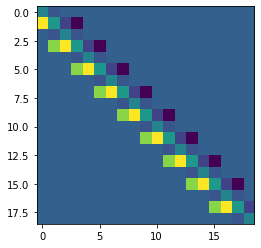

In [112]:
plt.imshow(jacobian_transpose.detach().numpy()[0,0])

# Visualize differences

In [113]:
diff = jacobian_transpose.movedim(-2, -1) - jacobian
diff

RuntimeError: The size of tensor a (19) must match the size of tensor b (5) at non-singleton dimension 3

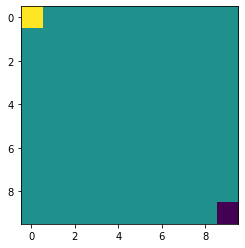

In [114]:
plt.imshow(diff.detach().numpy()[0,0])

# Alternative way


In [124]:
tmp.shape

torch.Size([1, 10, 10])

In [126]:
conv_net = nnj.Sequential(conv)
conv_net

Sequential(
  (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
)

In [136]:
output, jacobian_conv = conv_net(tmp.unsqueeze(0), jacobian = True)
jacobian_conv.shape, output.shape

(torch.Size([1, 1, 5, 5, 1, 10, 10]), torch.Size([1, 1, 5, 5]))

In [127]:
conv_transpose_net = nnj.Sequential(conv_transpose)
conv_transpose

ConvTranspose2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))

In [135]:
output, jacobian_conv_transpose_net = conv_transpose_net(tmp.unsqueeze(0), jacobian = True)
jacobian_conv_transpose_net.shape, output.shape

(torch.Size([1, 1, 19, 19, 1, 10, 10]), torch.Size([1, 1, 19, 19]))

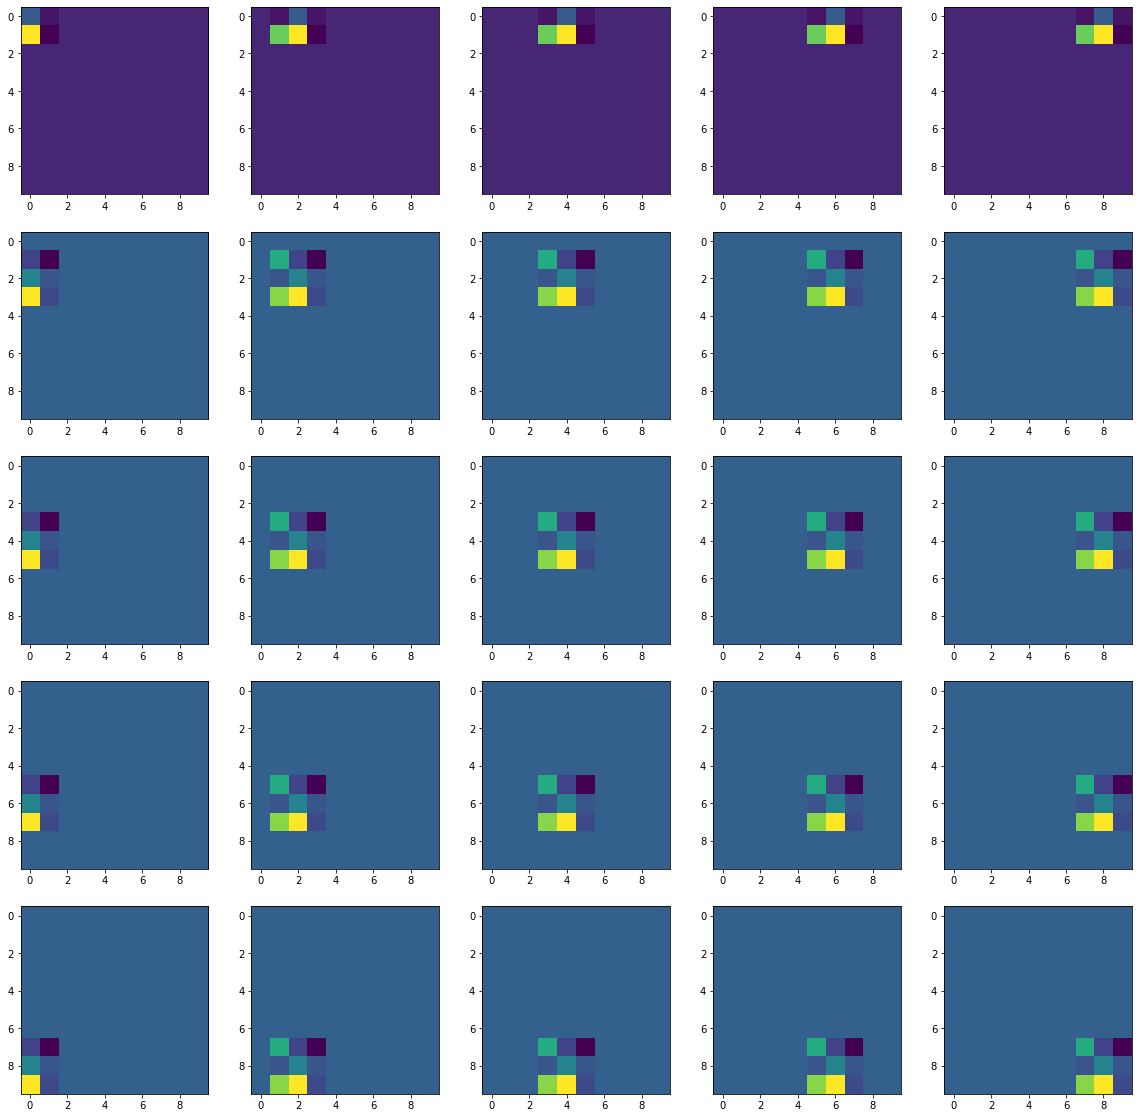

In [130]:
plt.figure(figsize=(20,20))
for i in range(5):
    for j in range(5):
        plt.subplot(5,5,1+i*5+j)
        plt.imshow(jacobian_conv[0,0,i,j,0,:,:].detach().numpy())
plt.show()

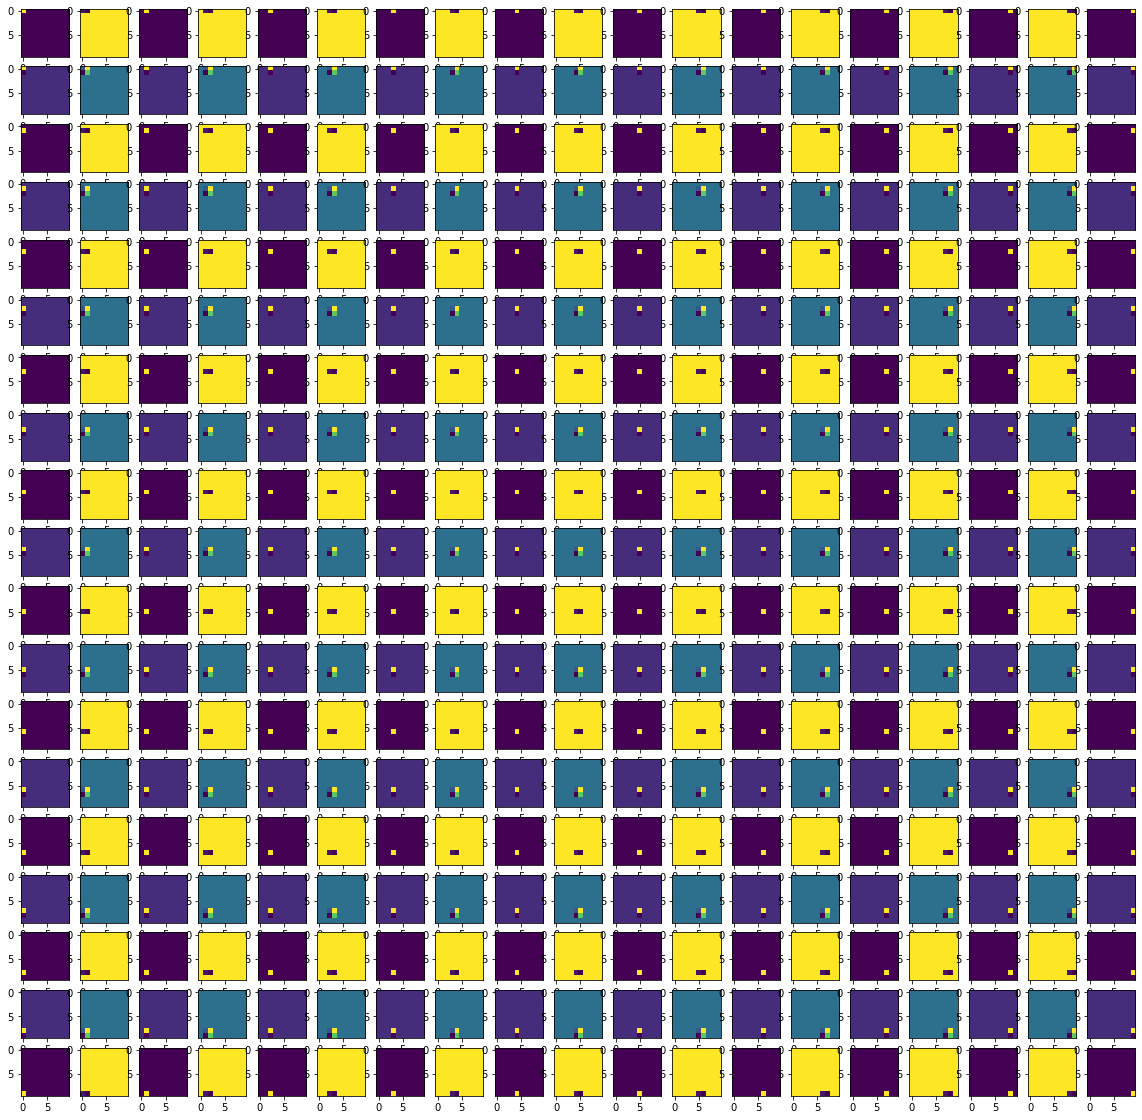

In [134]:
plt.figure(figsize=(20,20))
n = jacobian_conv_transpose_net.shape[2]
for i in range(n):
    for j in range(n):
        plt.subplot(n,n,1+i*n+j)
        plt.imshow(jacobian_conv_transpose_net[0,0,i,j,0,:,:].detach().numpy())
plt.show()